In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.impute import KNNImputer

In [3]:
# load data (latest version of output from script/notebook before) - "6.1_weather_parameters.csv"

merged_df_origin = pd.read_csv("/workspaces/bakery_sales_prediction/sourcedata/cleaned_data/6.1_weather_parameters.csv")

merged_df = merged_df_origin.copy()

print(merged_df_origin.head(), "\n")
print(merged_df_origin.info())

print("Missing values in each column:")
print(merged_df.isna().sum())

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0  2013-07-01         6.0     17.8375                 15.0        20.0   
1  2013-07-01         6.0     17.8375                 15.0        20.0   
2  2013-07-01         6.0     17.8375                 15.0        20.0   
3  2013-07-01         6.0     17.8375                 15.0        20.0   
4  2013-07-01         6.0     17.8375                 15.0        20.0   

   KielerWoche  Warengruppe      Umsatz  Feiertage  Ferientage  Niederschlag  
0          0.0          1.0  148.828353        0.0         1.0           0.3  
1          0.0          2.0  535.856285        0.0         1.0           0.3  
2          0.0          3.0  201.198426        0.0         1.0           0.3  
3          0.0          4.0   65.890169        0.0         1.0           0.3  
4          0.0          5.0  317.475875        0.0         1.0           0.3   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data 

### Investigate Data

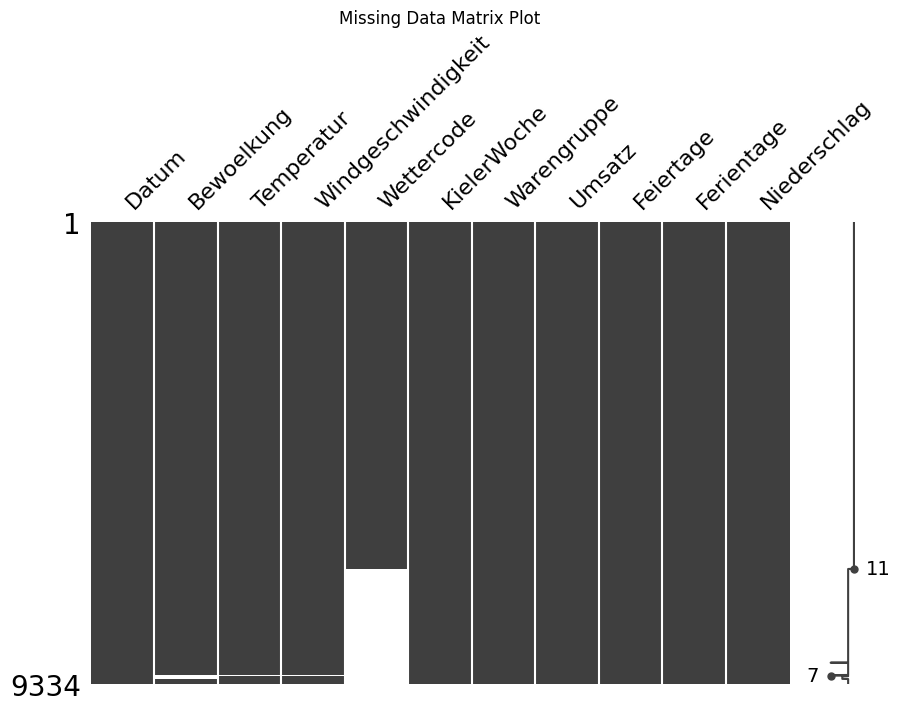

In [7]:
# Matrix plot of missing data for visualization
msno.matrix(merged_df, figsize=(10, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

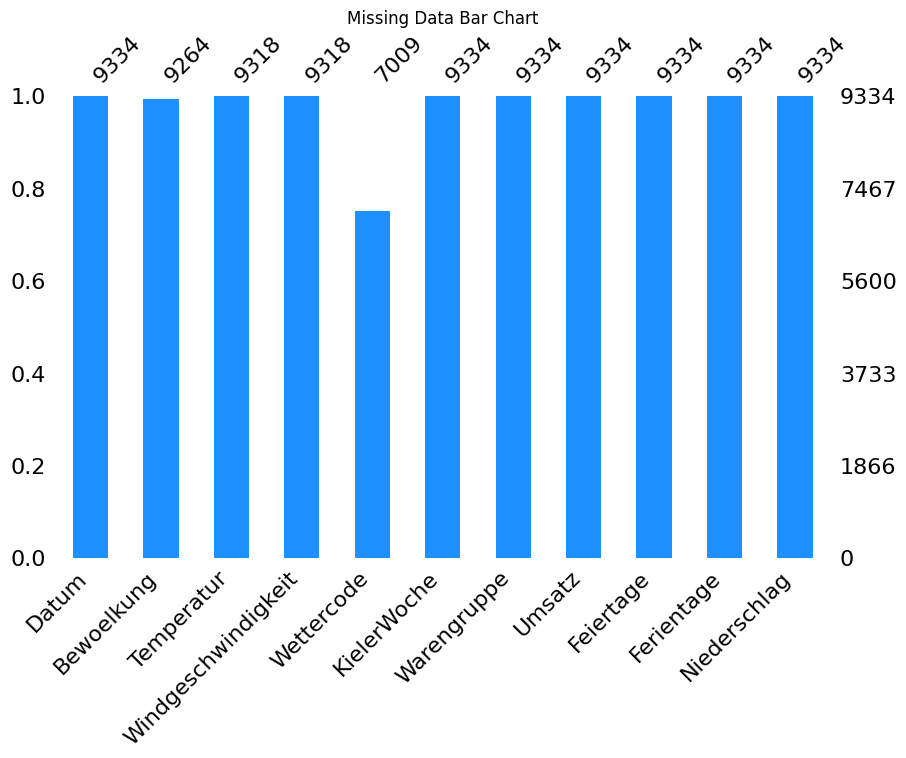

In [8]:
# Bar plot of missing data
msno.bar(merged_df_origin, color="dodgerblue", figsize=(10, 6)) # log=True for emphasising missing values
plt.title('Missing Data Bar Chart')
plt.show()

### Impute missing values

We do not know why values are missing in weather code data (and also the other datasets we use) so we assume it is missing completely at random (MCAR).
A listwise deletion of all rows with missing values would cost us too many datapoints (e.g. for "Wettercode" we have 9334 dates but only 7009 with valid weather code. If we delete all dates with missing datapoints, this would cost us roughly 20% of our information and that is a lot!)
So we decided to fill the data. Since the **weathercode** is categorial and not numeric, we cannot use a method based on distance or statistical metrics like average.
We chose to use **KNN (K-nearest neighbour)** method because we have other columns like cloudiness and precipitation and temperature and windspeed which influence the weather and therefore might have influence on the weathercode and could help fill the weathercode through similarities.

But first we need to fill the missing values from the other columns which have less missing points. In the case of **cloudiness** we use the **mode imputation** which fills the missing values with the most common value.

For **temperature** and **windspeed** and as well **precipitation** (although not sure if it is good for precipitation - we are not meteorologists) we use a **linear interpolation**. This means that a missing value is filled with the average of the last non-missing value and the next. 

In [9]:
# mode imputation for cloudiness

# Function to create a mask column for imputed values
def create_imputation_mask(df, column_name):
    mask_name = f'imp_mask_{column_name}'
    mask = df[column_name].isna().astype(int)  # 1 for missing values, 0 for original values
    return mask_name, mask

# Create mask for 'Bewoelkung'
bew_mask_name, bew_mask = create_imputation_mask(merged_df, 'Bewoelkung')

# Find the mode of the 'cloudiness' column
mode_cloudiness = merged_df['Bewoelkung'].mode()[0]

# Impute missing values with the mode
merged_df['Bewoelkung'].fillna(mode_cloudiness, inplace=True)

# Add mask column to the dataframe
merged_df[bew_mask_name] = bew_mask

print(f"Mode of 'Bewoelkung'{mode_cloudiness}")
print(merged_df['Bewoelkung'].head(15))

print(merged_df.info("Bewoelkung")) # check if all values are non-null


Mode of 'Bewoelkung'7.0
0     6.0
1     6.0
2     6.0
3     6.0
4     6.0
5     7.0
6     7.0
7     7.0
8     7.0
9     7.0
10    7.0
11    7.0
12    7.0
13    7.0
14    7.0
Name: Bewoelkung, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                9334 non-null   object 
 1   Bewoelkung           9334 non-null   float64
 2   Temperatur           9318 non-null   float64
 3   Windgeschwindigkeit  9318 non-null   float64
 4   Wettercode           7009 non-null   float64
 5   KielerWoche          9334 non-null   float64
 6   Warengruppe          9334 non-null   float64
 7   Umsatz               9334 non-null   float64
 8   Feiertage            9334 non-null   float64
 9   Ferientage           9334 non-null   float64
 10  Niederschlag         9334 non-null   float64
 11  imp_mask_Bewoelkung  9334 non-n

/tmp/ipykernel_22086/2989050151.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Bewoelkung'].fillna(mode_cloudiness, inplace=True)


In [10]:
# linear interpolation for windspeed, temperature, and precipitation

# Function to create a mask column for interpolated values
def create_interpolation_mask(df, column_name):
    mask_name = f'imp_mask_{column_name}'
    mask = df[column_name].isna().astype(int)  # 1 for missing values, 0 for original values
    return mask_name, mask

# Create masks for each column
temp_mask_name, temp_mask = create_interpolation_mask(merged_df, 'Temperatur')
wind_mask_name, wind_mask = create_interpolation_mask(merged_df, 'Windgeschwindigkeit')
precip_mask_name, precip_mask = create_interpolation_mask(merged_df, 'Niederschlag')

# Interpolate missing values for Precipitation and WindSpeed
merged_df['Temperatur'] = merged_df['Temperatur'].interpolate(method='linear')
merged_df['Windgeschwindigkeit'] = merged_df['Windgeschwindigkeit'].interpolate(method='linear')
merged_df['Niederschlag'] = merged_df['Niederschlag'].interpolate(method='linear')

# Fill any remaining NaNs (e.g., at the beginning or end) using forward fill
merged_df['Temperatur'].fillna(method='bfill', inplace=True)
merged_df['Windgeschwindigkeit'].fillna(method='bfill', inplace=True)
merged_df['Niederschlag'].fillna(method='bfill', inplace=True)

# Add mask columns to the dataframe
merged_df[temp_mask_name] = temp_mask
merged_df[wind_mask_name] = wind_mask
merged_df[precip_mask_name] = precip_mask

# Display the DataFrame after interpolation
print(merged_df.info()) # check if all values are non-null


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Datum                         9334 non-null   object 
 1   Bewoelkung                    9334 non-null   float64
 2   Temperatur                    9334 non-null   float64
 3   Windgeschwindigkeit           9334 non-null   float64
 4   Wettercode                    7009 non-null   float64
 5   KielerWoche                   9334 non-null   float64
 6   Warengruppe                   9334 non-null   float64
 7   Umsatz                        9334 non-null   float64
 8   Feiertage                     9334 non-null   float64
 9   Ferientage                    9334 non-null   float64
 10  Niederschlag                  9334 non-null   float64
 11  imp_mask_Bewoelkung           9334 non-null   int64  
 12  imp_mask_Temperatur           9334 non-null   int64  
 13  imp

/tmp/ipykernel_22086/3262025803.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Temperatur'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_22086/3262025803.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Temperatur'].fillna(method='bfill', inplace=True)
/tmp/ipykernel_22086/3262025803.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using a

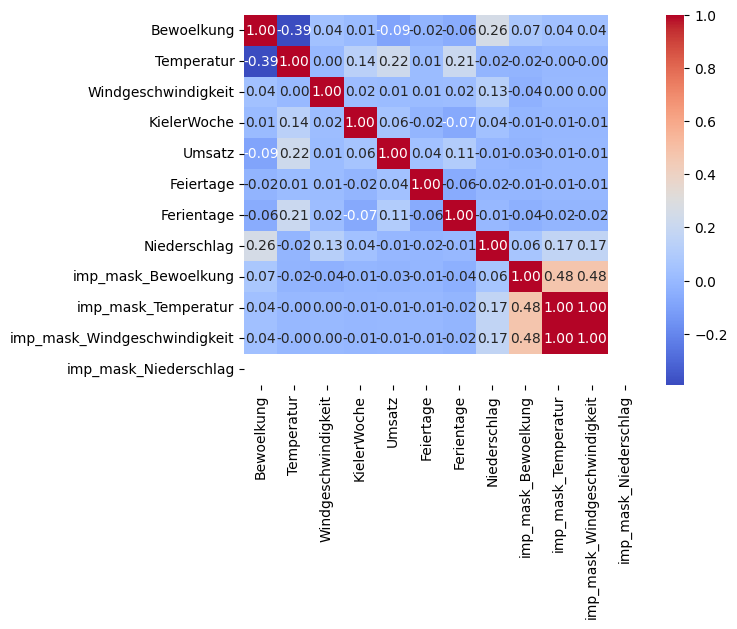

In [11]:
# correlation matrix

# Drop the 'Datum' column
df_numeric = merged_df.drop(columns=['Datum', 'Wettercode', 'Warengruppe']) 
# it is not helpful to include categorical variables into the matrix without encoding them

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Display the heatmap
plt.show()

In [12]:
# KNN imputation for Wettercode

# Step 1: Create a mask for NaN values
imp_mask_Wettercode = merged_df['Wettercode'].isna().astype(int)

# Step 2: Select columns for imputation
columns_for_imputation = ['Niederschlag', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode']
imputation_df = merged_df[columns_for_imputation].copy()

# Step 3: Apply KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputed_data = imputer.fit_transform(imputation_df)

# Step 4: Ensure the imputed values for Wettercode remain integers within the range (0-99)
# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=columns_for_imputation)

# Round and clip Wettercode values to ensure they are integers within the valid range
imputed_df['Wettercode'] = np.round(imputed_df['Wettercode']).astype(int)
imputed_df['Wettercode'] = np.clip(imputed_df['Wettercode'], 0, 99)

# Step 5: Merge the imputed Wettercode back to the original dataframe, keeping original values
result_df = merged_df.copy()
result_df['Wettercode'] = merged_df['Wettercode'].combine_first(imputed_df['Wettercode'])

# Add mask column to indicate which values were imputed
result_df['imp_mask_Wettercode'] = imp_mask_Wettercode

print(result_df)

           Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0     2013-07-01         6.0     17.8375                 15.0        20.0   
1     2013-07-01         6.0     17.8375                 15.0        20.0   
2     2013-07-01         6.0     17.8375                 15.0        20.0   
3     2013-07-01         6.0     17.8375                 15.0        20.0   
4     2013-07-01         6.0     17.8375                 15.0        20.0   
...          ...         ...         ...                  ...         ...   
9329  2018-07-31         5.0     31.2875                 11.0        21.0   
9330  2018-07-31         5.0     31.2875                 11.0        21.0   
9331  2018-07-31         5.0     31.2875                 11.0        21.0   
9332  2018-07-31         5.0     31.2875                 11.0        21.0   
9333  2018-07-31         5.0     31.2875                 11.0        21.0   

      KielerWoche  Warengruppe      Umsatz  Feiertage  Ferientage  \
0     

In [13]:
# check if the imputation succeeded and see if the range of values in the Wettercode are the same
print("\n merged_df:", merged_df['Wettercode'].describe())
print("\n result_df:", result_df['Wettercode'].describe())




 merged_df: count    7009.000000
mean       36.900128
std        27.095884
min         0.000000
25%        10.000000
50%        28.000000
75%        61.000000
max        95.000000
Name: Wettercode, dtype: float64

 result_df: count    9334.000000
mean       32.387615
std        27.354896
min         0.000000
25%         5.000000
50%        21.000000
75%        61.000000
max        95.000000
Name: Wettercode, dtype: float64


In [14]:
# Show value distribution to see how the imputed values are distributed
value_counts = merged_df['Wettercode'].value_counts().sort_index()
print(value_counts)
value_counts = result_df['Wettercode'].value_counts().sort_index()
print(value_counts)

Wettercode
0.0      815
3.0        5
5.0      562
10.0     742
17.0       5
20.0     244
21.0    1013
22.0      88
28.0      63
45.0      96
49.0      48
53.0      31
61.0    2271
63.0     535
65.0     111
68.0      12
69.0      27
71.0      81
73.0      48
75.0      25
77.0      45
79.0       5
95.0     137
Name: count, dtype: int64
Wettercode
0.0     1497
3.0       25
4.0       10
5.0      988
10.0     966
12.0       5
17.0      15
20.0     339
21.0    1386
22.0      89
28.0      83
37.0       5
45.0     107
49.0      75
53.0      31
61.0    2575
63.0     577
65.0     131
68.0      17
69.0      27
71.0      96
73.0      48
75.0      25
77.0      50
79.0       5
95.0     162
Name: count, dtype: int64


In [15]:
# check of missing values are filled:

print("Missing values in each column:")
print(result_df.isna().sum())

Missing values in each column:
Datum                           0
Bewoelkung                      0
Temperatur                      0
Windgeschwindigkeit             0
Wettercode                      0
KielerWoche                     0
Warengruppe                     0
Umsatz                          0
Feiertage                       0
Ferientage                      0
Niederschlag                    0
imp_mask_Bewoelkung             0
imp_mask_Temperatur             0
imp_mask_Windgeschwindigkeit    0
imp_mask_Niederschlag           0
imp_mask_Wettercode             0
dtype: int64


### Save result:

In [11]:
# Save the updated data to new CSV files
result_df.to_csv('../sourcedata/cleaned_data/6.2_missing_value_imputation.csv', sep=',', index=False)